# Convolutional Neurale Netværk med Keras
I den næste kode blok er der kodet et simpelt convolutional neurale netværk (CNN) til at genkende tal fra MNISTs håndskrevne tal datasettet. Eksemplet er taget fra [keras hjemmeside](https://keras.io/examples/vision/mnist_convnet/). 

## Importering
Her importerer vi de pakker vi skal bruge. Keras kan bruge mange forskellige neurale netværk pakker til at virke, vi sætter den op til at bruge pytorch.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras_core as keras
from keras_core import layers


Using PyTorch backend.


## Datasæt importering
Heldigvis kan man overfør MNIST datasætet ved bruge af et funktion fra keras. Her overfører vi datasætet, hvor den bliver splittet til training og testing splits.

In [2]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Check shape of images and labels
print("Images shape:", x_train.shape)
print("Labels shape:", y_train.shape)
print("Number of classes:", len(np.unique(y_train)))

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

Images shape: (60000, 28, 28)
Labels shape: (60000,)
Number of classes: 10


Vi laver en loop igennem datasætet og viser et billede fra hvert cifre

/tmp/ipykernel_53293/699801886.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  Fig.show()


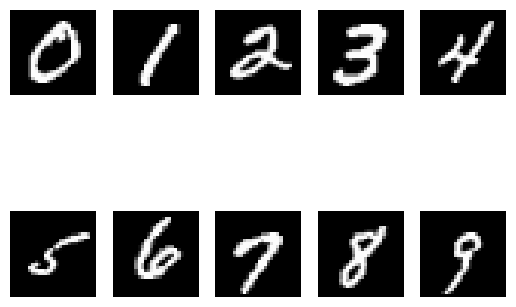

In [3]:
Fig, ax = plt.subplots(2, 5)
label_to_print = 0
for img, label in zip(x_train, y_train):
    if label == label_to_print:
        ax[label_to_print // 5, label_to_print % 5].imshow(img, cmap="gray")
        ax[label_to_print // 5, label_to_print % 5].axis("off")
        label_to_print += 1
    if label_to_print == num_classes:
        break
Fig.show()

Derefter vi laver billedernes pixler fra heltal mellem [0,255] til decimaltal mellem [0,1], fordi neurale netværk algoritmerne virker bedre med normaliseret værdier.

De sidste to linjer laver billed labels fra nummer til [one-hot encoded](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) vektorer.

In [4]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Model initialisering
Derafter laver vi CNN modelen som vi skal træne til at genkende talene. Her bruges der kun to convolutional lag til at finde mønstre og en sidste almindelig neurale netværk lag (Dense) til at bruge de der mønstre til at lave sandsynlighed for hvilket nummer billedet er.

De convolutional lag bruger RELU som aktivering funktion, og den sidste dense lag bruger softmax fordi dens output vektor skal være en sandsynlighedsvektor.

Imellem hver convolutional lag er der en Max Pooling lag, som gør billederne mindre og gør det nemmere at have flere convolution kanaler.

In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 10)                │     16,010 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

## Model træning
Her sætter vi alle de værdier der skal bruges til at træne modellen, og så træner vi den.

Først sætter vi vores batch size, som bestemmer hvor mange billeder vi sender igennem modellen før vi tager et weight opdatering step. Derefter vi vælger antal epochs, som bestemmer hvor mange gange vi vil gerne sende hele træning sætet igennem modellen.

Under compile metoden vi bestemer loss funktion, optimering algoritmer, og hvordan vi vil gerne mål modellens performance på validering sættet. Vi bruger categorical_crossentropy, som er den mest brugt loss funktion til klassifikation. Vi bruger også simpelt stochastic gradient descent (SGD) til optimering, og procentdel af rigtige klassifikationer til at mål modellens performance.

In [6]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3924 - loss: 1.9386 - val_accuracy: 0.8868 - val_loss: 0.4149
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8767 - loss: 0.4282 - val_accuracy: 0.9323 - val_loss: 0.2475
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9097 - loss: 0.3086 - val_accuracy: 0.9450 - val_loss: 0.2041
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9265 - loss: 0.2498 - val_accuracy: 0.9558 - val_loss: 0.1657
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9380 - loss: 0.2075 - val_accuracy: 0.9595 - val_loss: 0.1493


## Testing af Vores Model
Til sidst bruger vi de 10 tusind test billeder til at evaluerer hvor god vores trænet model er til at klassifikerer billeder den har ikke set før.

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.16550849378108978
Test accuracy: 0.9523000121116638


# Opgaver

Experimentering opgaver findes i Playground_CNN.ipynb.